# An Exploration of Several Clustering Algorithms
## April 8th, 2019
### Dr Jose M Albornoz

In this notebook several clustering algorithms are explored, highlighting their advantages and disadvantages.


# Import necessary modules

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
cmap = 'tab10'
%matplotlib inline

import numpy as np

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import hdbscan

RANDOM_STATE = 801

# 1.- Generate synthetic data

"Neat" and "messy" datasets are created

In [2]:
# cluster centres
centers_neat = [(-10, 10), (0, -5), (10, 5)]

x_neat, _ = datasets.make_blobs(n_samples=5000, centers=centers_neat, cluster_std=2, random_state=RANDOM_STATE)

x_messy, _ = datasets.make_classification(n_samples=5000,
                                          n_features=10,
                                          n_classes=3,
                                          n_clusters_per_class=1,
                                          class_sep=1.5,
                                          shuffle=False,
                                          random_state=RANDOM_STATE)

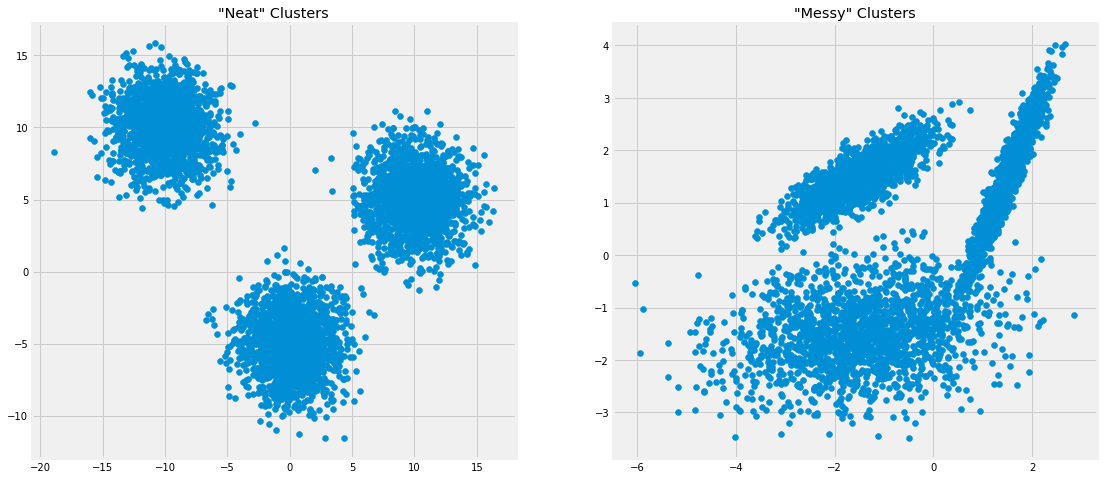

In [3]:
plt.figure(figsize=(17,8))
plt.subplot(121, title='"Neat" Clusters')
plt.scatter(x_neat[:,0], x_neat[:,1])
plt.subplot(122, title='"Messy" Clusters')
plt.scatter(x_messy[:,0], x_messy[:,1])

# 2.- K-means

Let's see how the k-menas algorithms fares clustering the above data sets.

In [4]:
km_neat = KMeans(n_clusters=3, random_state=RANDOM_STATE).fit_predict(x_neat)
km_messy = KMeans(n_clusters=3, random_state=RANDOM_STATE).fit_predict(x_messy)

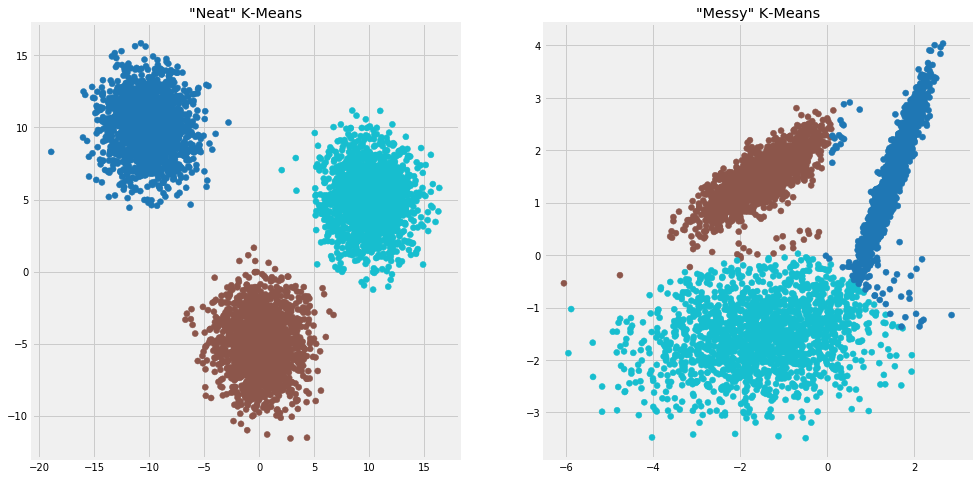

In [5]:
plt.figure(figsize=(15,8))
plt.subplot(121, title='"Neat" K-Means')
plt.scatter(x_neat[:,0], x_neat[:,1], c=km_neat, cmap=cmap)
plt.subplot(122, title='"Messy" K-Means')
plt.scatter(x_messy[:,0], x_messy[:,1], c=km_messy, cmap=cmap)

Thye performance of k-means on the messy dataset is sub-optimal: our messy clusters are of varying shapes and variances, which proves challenging for K-means to work with; furthermore the clusters are not well separated. 

# 3.- Gaussian Mixture Models

GMMs fit a number of normal distributions to our data set by estimating their parameters using expectation maximization. This is a two-step iterative algorithm (in some ways similar to K-means):

1. Expectation: Generate a number of distributions with reasonable parameters (mean and variance) based on the given data, then "ask" every data point how likely is it to fall within each. As with K-means, you need to specify the number of clusters (also called "components") a priori.

2. Maximization: Iterate and update our distribution parameters to maximize the data points' likelihood of being assigned to the most probable cluster.

In [6]:
gm_messy = GaussianMixture(n_components=3).fit(x_messy).predict(x_messy)

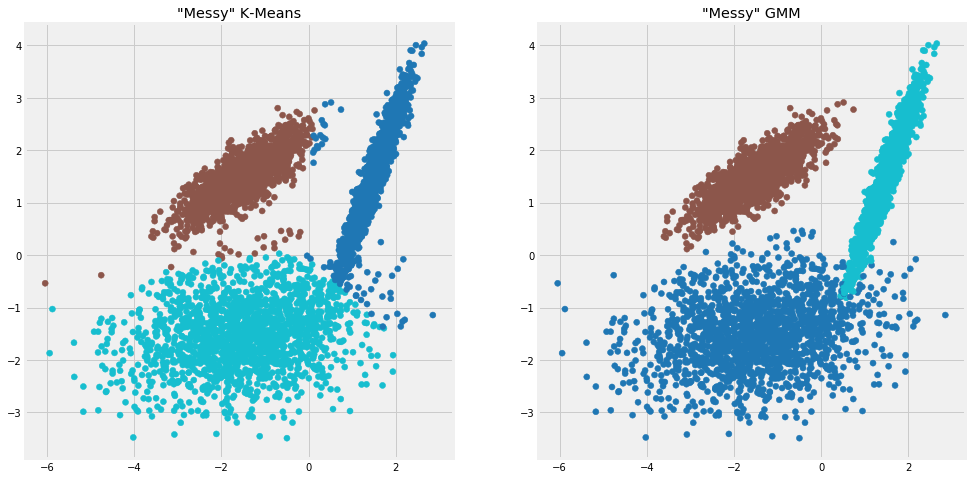

In [7]:
plt.figure(figsize=(15,8))
plt.subplot(121, title='"Messy" K-Means')
plt.scatter(x_messy[:,0], x_messy[:,1], c=km_messy, cmap=cmap)
plt.subplot(122, title='"Messy" GMM')
plt.scatter(x_messy[:,0], x_messy[:,1], c=gm_messy, cmap=cmap)

* Pros: GMM allows data to vary anisotropically and provides probability estimates of cluster membership rather than "hard labeling" data points like K-means.

* Cons: GMM still assumes normal distributions across dimensions and requires the number of components/clusters are specified a priori.

# 4.- Imbalanced Cluster Membership

This time we create clusters with very differnt number of points:

In [8]:
blob1, y1 = datasets.make_blobs(n_samples=25,
                               centers=[(10,5)],
                               cluster_std=1.5,
                               random_state=2)

blob2, y2 = datasets.make_blobs(n_samples=500,
                               centers=[(6,2)],
                               cluster_std=1.3,
                               random_state=2)

blob3, y3 = datasets.make_blobs(n_samples=500,
                               centers=[(2,5)],
                               cluster_std=1,
                               random_state=2)

unbal = np.vstack([blob1, blob2, blob3])
y1[y1 == 0] = 0
y2[y2 == 0] = 1
y3[y3 == 0] = 2
labs = np.concatenate([y1, y2, y3])

## 4.1.- Predict cluster membership with k-means

In [9]:
km_unbal = KMeans(n_clusters=3, random_state=2).fit(unbal)
km_unbal_preds = KMeans(n_clusters=3, random_state=RANDOM_STATE).fit_predict(unbal)

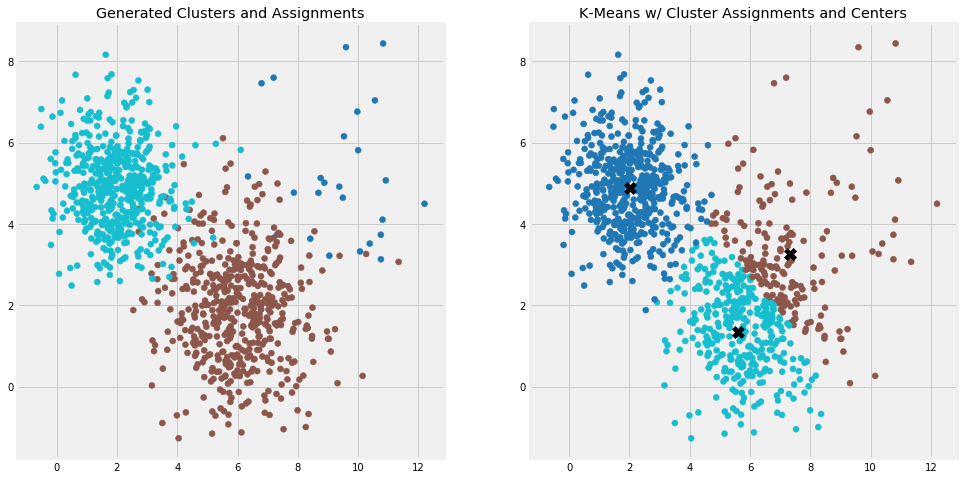

In [10]:
plt.figure(figsize=(15,8))
plt.subplot(121, title='Generated Clusters and Assignments')
plt.scatter(unbal[:,0], unbal[:,1], c=labs, cmap=cmap)
plt.subplot(122, title='K-Means w/ Cluster Assignments and Centers')
plt.scatter(unbal[:,0], unbal[:,1], c=km_unbal_preds, cmap=cmap)
plt.scatter(km_unbal.cluster_centers_[:,0], km_unbal.cluster_centers_[:,1], marker='X', s=150, c='black')

Since the K-means algorithm is trying to minimize the sum or squared differences within each cluster, our centroids are naturally "pulled" towards larger, denser clusters. 

What if some data points don't belong in any cluster? What if they are outliers or noise? Both K-means and GMMs include every data point in a cluster no matter how far away it is from the nearest centroid.

## 4.2.- Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)

DBSCAN differs from K-means in several ways:

* DBSCAN does not require the analyst to select the number of clusters a priori — the algorithm determines this based on the parameters it's given.

* It excels at clustering non-spherical data.

* It does not force every data point into a cluster — if a data point lies outside of the specified starting parameters, it will be classified as "noise" and not included in any resulting cluster.

Rather than randomly initialize centroids within our 2D data set and shuffle them into the best position, DBSCAN looks at each data point individually. DBSCAN relies on two parameters:

* Epsilon, or "eps,": A measure of radial distance extending from a data point. A larger epsilon means a larger distance from a data point is considered when determining if another data point should be considered in its "neighborhood" and vice versa.

* Minimum points: The number of other data points within a data point's "neighborhood" for it to be considered a "core" data point.

Let's visualise this:

In [11]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://i.stack.imgur.com/5aikc.png")

The radius of the circles from each data point represent epsilon; for a data point to be considered "core" and therefore "clusterable," it needs to have the minimum number of data points falling within its epsilon radius (in the above example, that number is four including the data point itself). "Border" points are also in the core clusters and form their edges. The blue data point has neither the minimum number of data points in its neighborhood nor does it fall within a core data point's neighborhood and is thus labeled as "noise."

A major drawback with DBSCAN is that it's sensitive to the epsilon and minimum points parameters you give it. 

HDBSCAN allows for clusters of differing variances and densities, requiring only one parameter: minimum cluster size; this is highly intuitive from a business standpoint.

HDBSCAN follows the same principles used in hierarchical/agglomerative clustering: every data point starts as part of its own cluster and iteratively clusters with the next nearest data points until all data points are clustered together. The minimum cluster size parameter allows us to discard clusters below this threshold.

In [12]:
clust_count = np.linspace(1, 20, num=20, dtype='int')

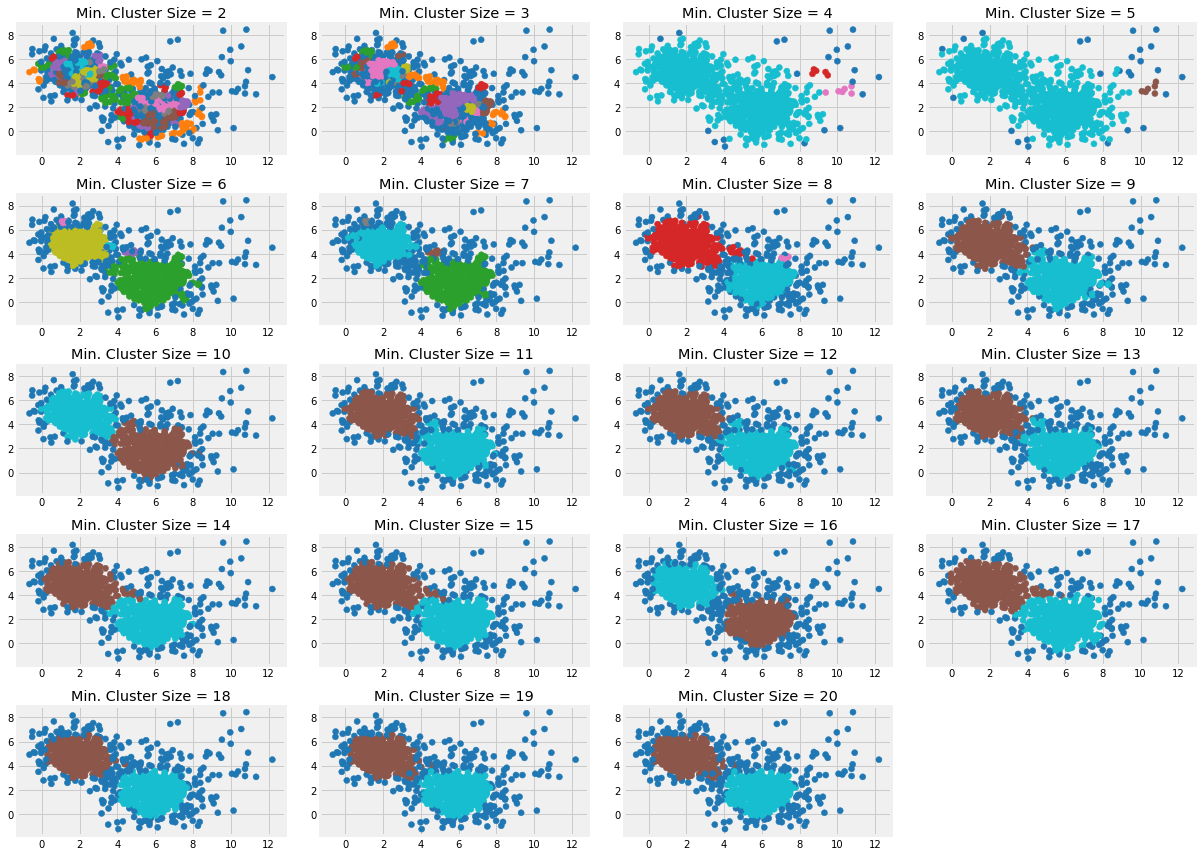

In [13]:
clust_number = 2
plot_number = 1
plt.figure (figsize=(17,12))
while clust_number < 21:
    hdb = hdbscan.HDBSCAN(min_cluster_size=clust_number)
    hdb_pred = hdb.fit(unbal)
    plt.subplot(5, 4, plot_number, title = 'Min. Cluster Size = {}'.format(clust_number))
    plt.scatter(unbal[:,0], unbal[:,1], c=hdb_pred.labels_, cmap=cmap)
    plot_number += 1
    clust_number += 1

plt.tight_layout()

Around a minimum cluster size of nine, two distinct clusters begin to form. Gradually increasing this value, we see that clusters get smaller with more and more data points labeled as noise (the darker blue colored ones).

Pros and cons of HDBSCAN:

* Pros: Does not require the number of clusters to be set a priori and allows for noisy data.

* Cons: Relies on the density of data points so sparse data sets may not work well and may lose efficiency on higher dimensional data sets.